# Variance Reduction Techniques

$\textbf{Theory from a lecture at LMU by Dr. Ari-Pekka Perkkiö}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import fima

In [2]:
T = 1
t = 0
x = 1
r = 0.05
sigma = 0.2

In [3]:
M_vanilla = 100000 # number of simulations for vanilla option

M_exotic = 5000 # number of simulations for exotic option
steps_exotic = 1000

### Control Variates

Define $Y = G(Z) - \beta (X - E[X])$

where $X$ is a new random variable with known mean.

Then $E[Y] = E[G(Z)] - \beta E[X] + \beta E[X] = E[G(Z)]$

and $Var[Y] = Var[G(Z)] - 2 \beta Cov[G(Z), X] + \beta^2 Var[X]$

If we choose the optimal $\beta = \frac{Cov[G(Z), X]}{Var[X]}$, then $Var[Y] = (1 - \rho^2_{G(Z), X}) Var[G(Z)]$ is minimized. It is reduced the more correlated $G(Z)$ and $X$ are.

In [4]:
def mc_control_variate_underlying(t, x, K, eta, optimize_eta, payoff, r, sigma, T):
    assets = fima.GBMpaths(x, r, sigma, T - t, eta)
    optimize_assets = fima.GBMpaths(x, r, sigma, T - t, optimize_eta)

    b = np.cov(optimize_assets[-1], np.exp(-r*(T-t)) * payoff(optimize_assets, K))[0, 1] / np.var(optimize_assets[-1])

    payoffs = np.exp(-r*(T-t)) * payoff(assets, K) - b*(assets[-1] - x*np.exp(r*(T-t)))

    means = np.cumsum(payoffs) / np.arange(1, len(payoffs) + 1)

    #we should do this but this is way to slow in python if implemented like this
    #interval_range = 1.96 * ([np.std(payoffs[:n]) for n in range(1, len(payoffs) + 1)] / np.sqrt(np.arange(1, len(payoffs) + 1)))
    #so we do this instead
    interval_range = 1.96 * np.std(payoffs) / np.sqrt(np.arange(1, len(payoffs) + 1))

    return means, interval_range, b

in the money

In [5]:
eta = np.random.normal(size = (1, M_vanilla))
optimize_eta = np.random.normal(size = (1, int(M_vanilla/10)))

In [6]:
K = 0.8

true_price = fima.BS_call_price(t, x, K, r, sigma, T)
basic_means, basic_interval_range = fima.basic_mc(t=t, x=x, eta=eta, payoff=lambda x : fima.european_call_payoff(x, K), r=r, sigma=sigma, T = T)
control_variate_means, control_variate_interval_range, b = mc_control_variate_underlying(t=t, x=x, K=K, eta=eta, optimize_eta=optimize_eta, payoff=fima.european_call_payoff, r=r, sigma=sigma, T = T)

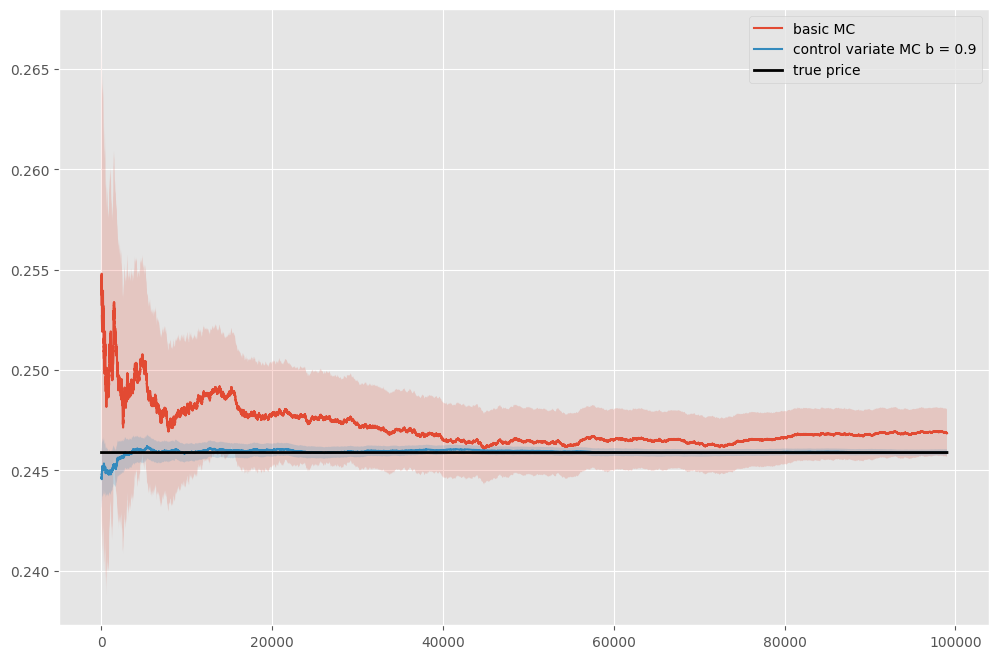

In [7]:
fima.plot_mc(basic_means, basic_interval_range, 'basic MC')
fima.plot_mc(control_variate_means, control_variate_interval_range, 'control variate MC b = ' + str(round(b, 2)))
fima.plot_true_price(true_price, M_vanilla)
plt.legend();

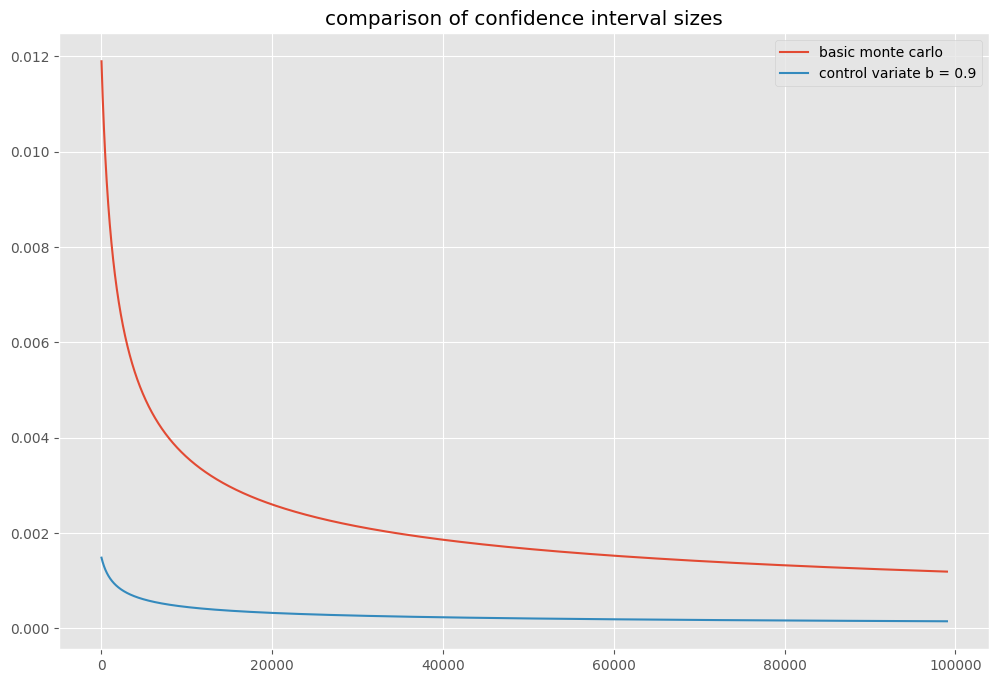

In [8]:
plt.plot(basic_interval_range[int(len(basic_interval_range) * fima.plot_bound):], label = 'basic monte carlo')
plt.plot(control_variate_interval_range[int(len(control_variate_interval_range) * fima.plot_bound):], label = 'control variate b = ' + str(round(b, 2)))
plt.title('comparison of confidence interval sizes')
plt.legend();

out of the money

In [9]:
K = 1.2


true_price = fima.BS_call_price(t, x, K, r, sigma, T)
basic_means, basic_interval_range = fima.basic_mc(t=t, x=x, eta=eta, payoff=lambda x : fima.european_call_payoff(x, K), r=r, sigma=sigma, T = T)
control_variate_means, control_variate_interval_range, b = mc_control_variate_underlying(t=t, x=x, K=K, eta=eta, optimize_eta=optimize_eta, payoff=fima.european_call_payoff, r=r, sigma=sigma, T = T)

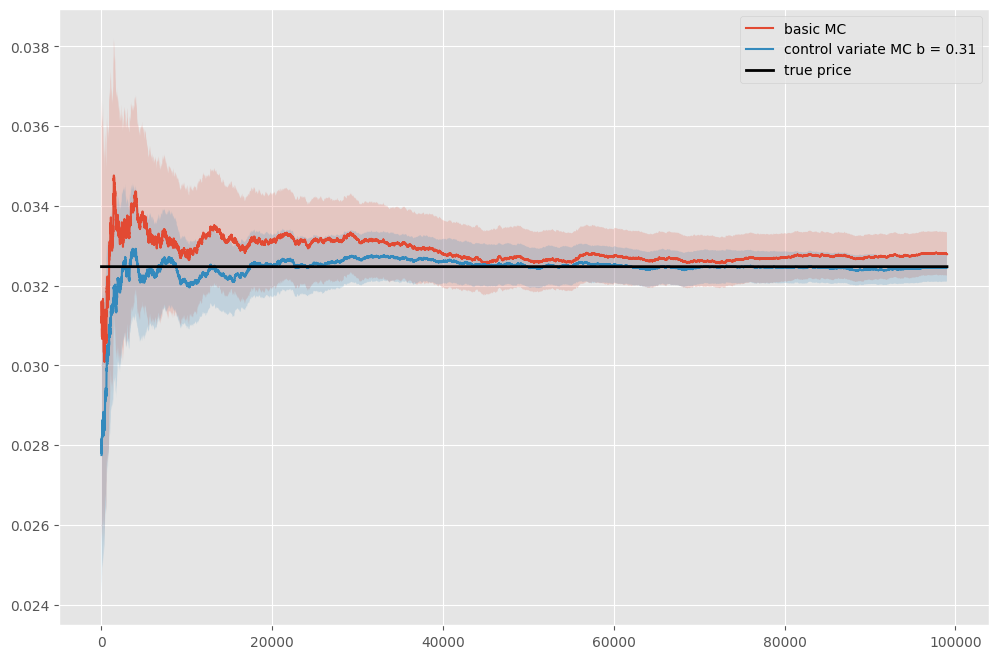

In [10]:
fima.plot_mc(basic_means, basic_interval_range, 'basic MC')
fima.plot_mc(control_variate_means, control_variate_interval_range, 'control variate MC b = ' + str(round(b, 2)))
fima.plot_true_price(true_price, M_vanilla)
plt.legend();

We will now estimate the price of an asian call, using an european call as control variate and compare the efficiency when deep in/out of the money

In [11]:
def mc_control_variate_european_call_non_vanilla_intervals(t, x, K, eta, optimize_eta, r = 0, sigma = 1, T = 1):
    assets = fima.GBMpaths(x, r, sigma, T - t, eta)
    optimize_assets = fima.GBMpaths(x, r, sigma, T - t, optimize_eta)

    b = np.cov(fima.asian_call_payoff(optimize_assets, K), fima.european_call_payoff(optimize_assets, K))[0, 1] / np.var(fima.european_call_payoff(optimize_assets, K))
    
    payoffs = np.exp(-r*(T-t)) * fima.asian_call_payoff(assets, K) - b*(np.exp(-r*(T-t))*fima.european_call_payoff(assets, K) - fima.BS_call_price(t, x, K, r, sigma, T))

    means = np.cumsum(payoffs) / np.arange(1, len(payoffs) + 1)

    #we should do this but this is way to slow in python if implemented like this
    #interval_range = 1.96 * ([np.std(payoffs[:n]) for n in range(1, len(payoffs) + 1)] / np.sqrt(np.arange(1, len(payoffs) + 1)))
    #so we do this instead
    interval_range = 1.96 * np.std(payoffs) / np.sqrt(np.arange(1, len(payoffs) + 1))

    return means, interval_range, b

in the money

In [12]:
eta = np.random.normal(size = (T*steps_exotic, M_exotic))
optimize_eta = np.random.normal(size = (T*steps_exotic, int(M_exotic/10)))

In [13]:
K = 0.8

basic_means, basic_interval_range = fima.basic_mc(t=t, x=x, eta=eta, payoff=lambda x : fima.asian_call_payoff(x, K), r=r, sigma=sigma, T = T)
control_variate_means, control_variate_interval_range, b = mc_control_variate_european_call_non_vanilla_intervals(t=t, x=x, K=K, eta=eta, optimize_eta=optimize_eta, r=r, sigma=sigma, T = T)

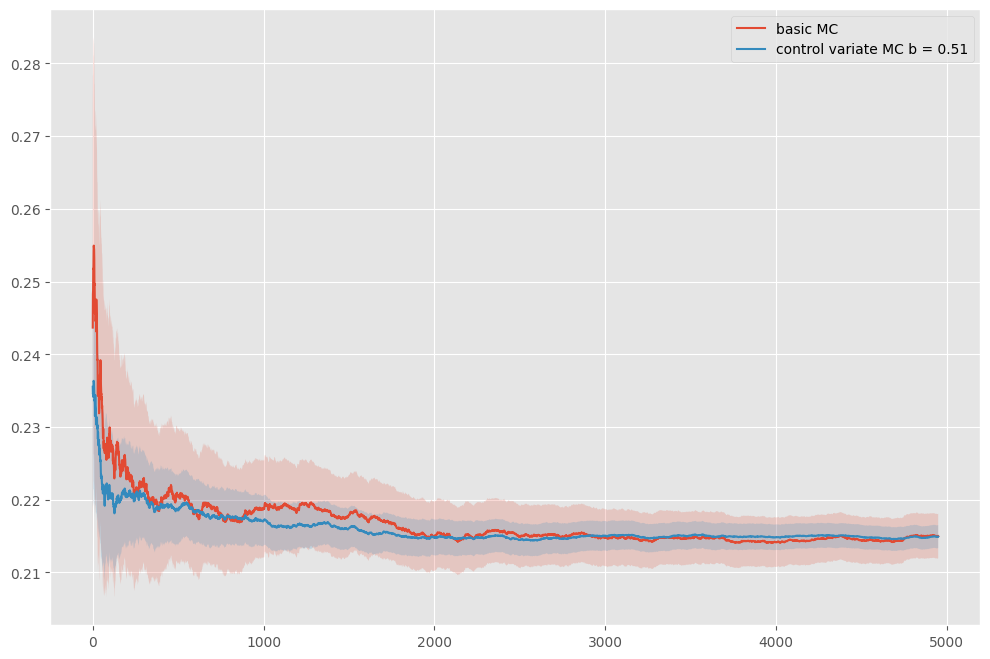

In [14]:
fima.plot_mc(basic_means, basic_interval_range, 'basic MC')
fima.plot_mc(control_variate_means, control_variate_interval_range, 'control variate MC b = ' + str(round(b, 2)))
plt.legend();

out of the money

In [15]:
K = 1.2

basic_means, basic_interval_range = fima.basic_mc(t=t, x=x, eta=eta, payoff=lambda x : fima.asian_call_payoff(x, K), r=r, sigma=sigma, T = T)
control_variate_means, control_variate_interval_range, b = mc_control_variate_european_call_non_vanilla_intervals(t=t, x=x, K=K, eta=eta, optimize_eta=optimize_eta, r=r, sigma=sigma, T = T)

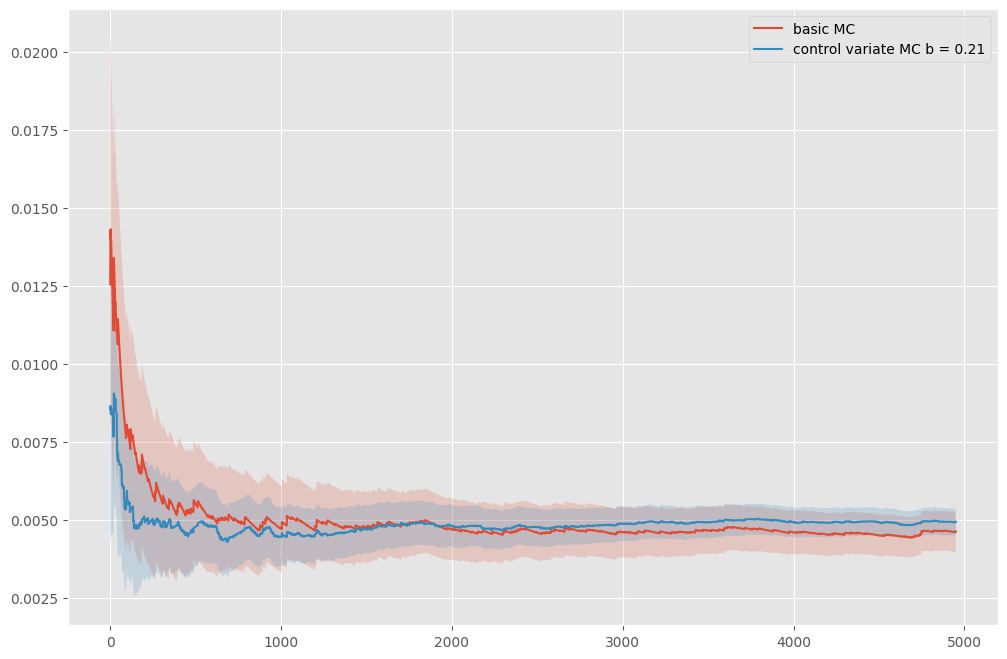

In [16]:
fima.plot_mc(basic_means, basic_interval_range, 'basic MC')
fima.plot_mc(control_variate_means, control_variate_interval_range, 'control variate MC b = ' + str(round(b, 2)))
plt.legend();